# Incorporating covariate information into classifiers

Daniel has shown that the sample data possesses covariates in <a href='https://github.com/cognoma/cancer-data/blob/master/3.explore-mutations.ipynb'>this notebook</a>. These may provide a spurious signal that a classifier accommodates for, and could confound attempts to pick out the actual signal we desire. This notebook will create a file with encoded information on these covariates that can be used as additional data to train on.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Let's peak at the sample data.

In [2]:
path = os.path.join('download', 'samples.tsv')
samples_df = pd.read_table(path, index_col=0)
samples_df.head(10)

,patient_id,sample_type,disease,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free
sample_id,,,,,,,,,,
TCGA-02-0047-01,TCGA-02-0047,Primary Tumor,glioblastoma multiforme,Brain,Male,78.0,1.0,448.0,NaN,NaN
TCGA-02-0055-01,TCGA-02-0055,Primary Tumor,glioblastoma multiforme,Brain,Female,62.0,1.0,76.0,NaN,NaN
TCGA-02-2483-01,TCGA-02-2483,Primary Tumor,glioblastoma multiforme,Brain,Male,43.0,0.0,466.0,NaN,NaN
TCGA-02-2485-01,TCGA-02-2485,Primary Tumor,glioblastoma multiforme,Brain,Male,53.0,0.0,470.0,NaN,NaN
TCGA-02-2486-01,TCGA-02-2486,Primary Tumor,glioblastoma multiforme,Brain,Male,64.0,0.0,493.0,NaN,NaN
TCGA-04-1348-01,TCGA-04-1348,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,44.0,1.0,1483.0,NaN,NaN
TCGA-04-1357-01,TCGA-04-1357,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,52.0,NaN,NaN,NaN,NaN
TCGA-04-1362-01,TCGA-04-1362,Primary Tumor,ovarian serous cystadenocarcinoma,Ovary,Female,59.0,1.0,1348.0,NaN,NaN
TCGA-05-4244-01,TCGA-05-4244,Primary Tumor,lung adenocarcinoma,Lung,Male,70.0,NaN,NaN,NaN,NaN


Let's get a sense of how much missing data there is.

In [3]:
print('Total number of samples: %d' % len(samples_df))
print('Number of nulls in each column:')
samples_df.isnull().sum(axis=0)

Total number of samples: 7306
Number of nulls in each column:


patient_id                 0
sample_type                0
disease                    0
organ_of_origin            0
gender                    19
age_diagnosed             50
dead                     111
days_survived            111
recurred                1638
days_recurrence_free    1638
dtype: int64

Now count the number of types of each column. We'll use Python's set, and therefore must exclude null values.

In [4]:
categorical_variables = ['sample_type', 'disease', 'organ_of_origin', 'gender','dead', 'recurred']
for variable in categorical_variables:
    not_null = samples_df[variable].notnull()
    count = len(set(samples_df.loc[not_null, variable]))
    print('Number of types in category %s: %d' % (variable, count))

Number of types in category sample_type: 1
Number of types in category disease: 32
Number of types in category organ_of_origin: 28
Number of types in category gender: 2
Number of types in category dead: 2
Number of types in category recurred: 2


There are no missing values from <code>sample_types</code> and only one possible value, so it is redundant and we'll exclude it.

In [5]:
del categorical_variables[categorical_variables.index('sample_type')]
print(categorical_variables)

['disease', 'organ_of_origin', 'gender', 'dead', 'recurred']


Inspecting the head of the samples DataFrame above, we see that two columns, namely <code>dead</code> and <code>recurred</code>, need some attention. We're going to encode categorical variables using panda's get_dummies. Since these columns are indicated by a 1 or 0, this will become the column header when encoded, as below.

In [6]:
pd.get_dummies(samples_df.dead).head(10)

,0.0,1.0
sample_id,,
TCGA-02-0047-01,0.0,1.0
TCGA-02-0055-01,0.0,1.0
TCGA-02-2483-01,1.0,0.0
TCGA-02-2485-01,1.0,0.0
TCGA-02-2486-01,1.0,0.0
TCGA-04-1348-01,0.0,1.0
TCGA-04-1357-01,0.0,0.0
TCGA-04-1362-01,0.0,1.0
TCGA-05-4244-01,0.0,0.0


Note that null values are encoded as (0,0) pairs.

Let's rename the values in each of these so that they more accurately reflect the underlying variable.

In [7]:
mortality_map = pd.Series(['alive', 'dead'], index=[0.0, 1.0])
samples_df.dead = samples_df.dead.map(mortality_map)
samples_df.dead.head(10)

sample_id
TCGA-02-0047-01     dead
TCGA-02-0055-01     dead
TCGA-02-2483-01    alive
TCGA-02-2485-01    alive
TCGA-02-2486-01    alive
TCGA-04-1348-01     dead
TCGA-04-1357-01      NaN
TCGA-04-1362-01     dead
TCGA-05-4244-01      NaN
TCGA-05-4249-01    alive
Name: dead, dtype: object

In [8]:
recurred_map = pd.Series(['has_not_recurred', 'has_recurred'], index=[0.0, 1.0])
samples_df.recurred = samples_df.recurred.map(recurred_map)
samples_df.recurred.head(10)

sample_id
TCGA-02-0047-01                 NaN
TCGA-02-0055-01                 NaN
TCGA-02-2483-01                 NaN
TCGA-02-2485-01                 NaN
TCGA-02-2486-01                 NaN
TCGA-04-1348-01                 NaN
TCGA-04-1357-01                 NaN
TCGA-04-1362-01                 NaN
TCGA-05-4244-01                 NaN
TCGA-05-4249-01    has_not_recurred
Name: recurred, dtype: object

Now when we concatenate, the columns are appropriately named, and the values are encoded as numeric data that can be input to the types of classifiers that we have been using.

In [9]:
pd.get_dummies(samples_df[['dead', 'recurred']]).head(10)

,dead_alive,dead_dead,recurred_has_not_recurred,recurred_has_recurred
sample_id,,,,
TCGA-02-0047-01,0.0,1.0,0.0,0.0
TCGA-02-0055-01,0.0,1.0,0.0,0.0
TCGA-02-2483-01,1.0,0.0,0.0,0.0
TCGA-02-2485-01,1.0,0.0,0.0,0.0
TCGA-02-2486-01,1.0,0.0,0.0,0.0
TCGA-04-1348-01,0.0,1.0,0.0,0.0
TCGA-04-1357-01,0.0,0.0,0.0,0.0
TCGA-04-1362-01,0.0,1.0,0.0,0.0
TCGA-05-4244-01,0.0,0.0,0.0,0.0


Another useful covariate will be the logarithm plus one function of the number mutations that was calculated in the aforementioned notebook.

In [10]:
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
mutation_df = pd.read_table(path, index_col=0)

In [11]:
mutation_df.head(2)

,1,2,3,9,10,12,13,14,15,16,...,106480741,106480770,106480897,106481627,106635537,106660612,107133486,107133516,107161144,107403068
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
number_of_mutations = mutation_df.sum(axis='columns')
number_of_mutations.head(2)

sample_id
TCGA-02-0047-01    39
TCGA-02-0055-01    33
dtype: int64

Let's process the entire thing. We'll convert the categorical variables to dummies, and then concatenate the numeric variables (age of diagnosis, days survived, and days recurrence free).

In [13]:
numeric_columns = ['age_diagnosed', 'days_survived', 'days_recurrence_free']
mutation_column = np.log1p(number_of_mutations)
covariates_df = pd.concat(
    [samples_df[numeric_columns], pd.get_dummies(samples_df[categorical_variables])],
    axis=1)
covariates_df['n_mutations_log1p'] = mutation_column
covariates_df.head()

,age_diagnosed,days_survived,days_recurrence_free,disease_adrenocortical cancer,disease_bladder urothelial carcinoma,disease_brain lower grade glioma,disease_breast invasive carcinoma,disease_cervical & endocervical cancer,disease_cholangiocarcinoma,disease_colon adenocarcinoma,...,organ_of_origin_Thymus,organ_of_origin_Thyroid Gland,organ_of_origin_Uterus,gender_Female,gender_Male,dead_alive,dead_dead,recurred_has_not_recurred,recurred_has_recurred,n_mutations_log1p
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,78.0,448.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.688879
TCGA-02-0055-01,62.0,76.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.526361
TCGA-02-2483-01,43.0,466.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.218876
TCGA-02-2485-01,53.0,470.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.688879
TCGA-02-2486-01,64.0,493.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.688879


Finally, let's save this to a <code>.tsv</code> file.

In [14]:
path = os.path.join('download', 'covariates.tsv')
covariates_df.to_csv(path, sep='\t')

Now some exploratory data visualization for imputing missing numeric values. First, the plot of age versus number of mutations from the previous notebook.

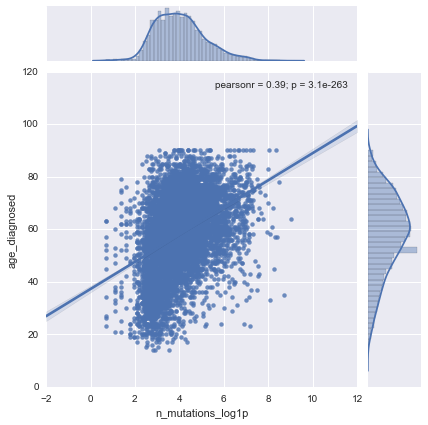

In [15]:
sns.jointplot('n_mutations_log1p', 'age_diagnosed', data=covariates_df, kind='reg')
plt.show()

Would we be comfortable using this to impute missing <code>age_diagnosed</code> values? Perhaps it makes sense to slice on different diseases...

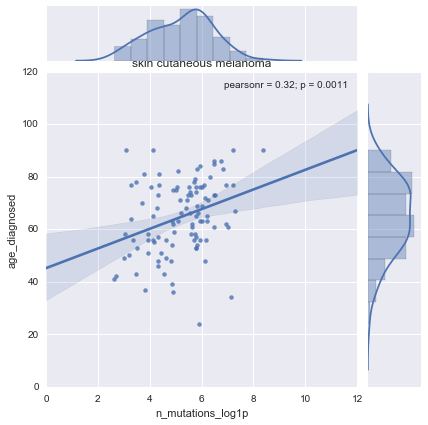

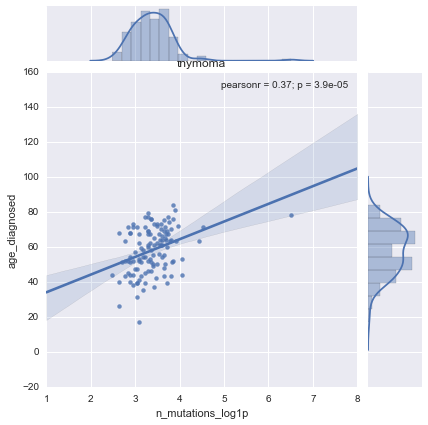

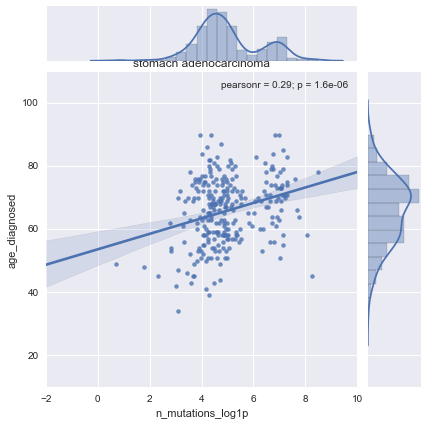

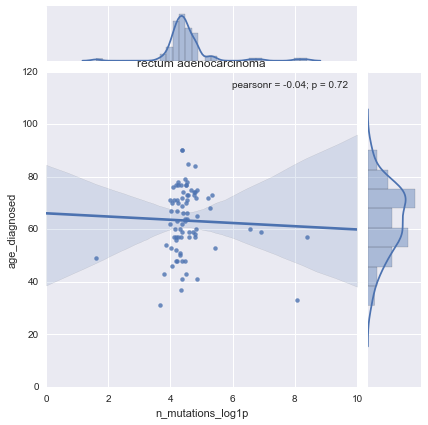

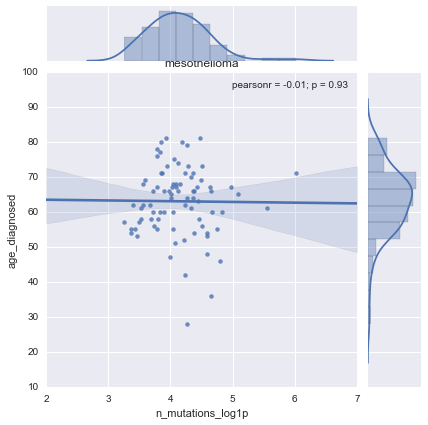

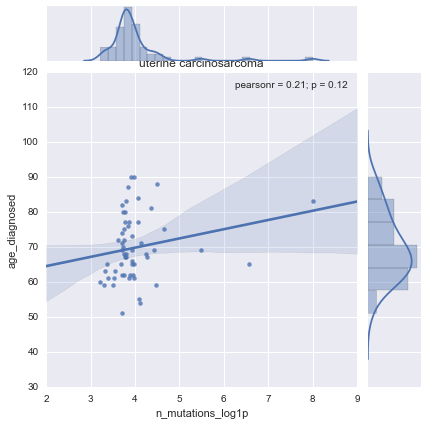

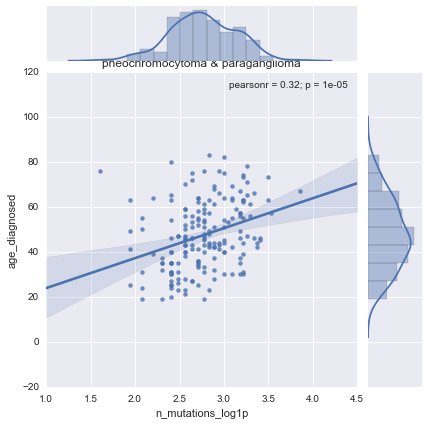

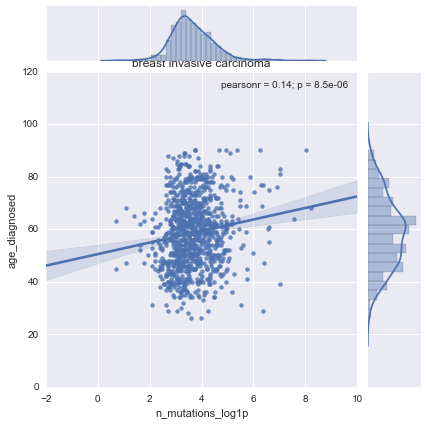

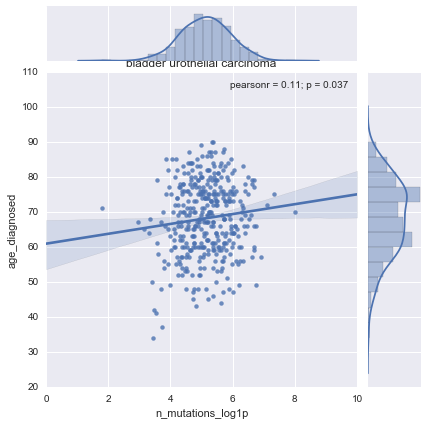

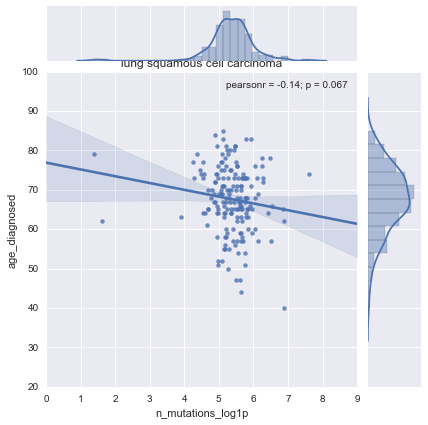

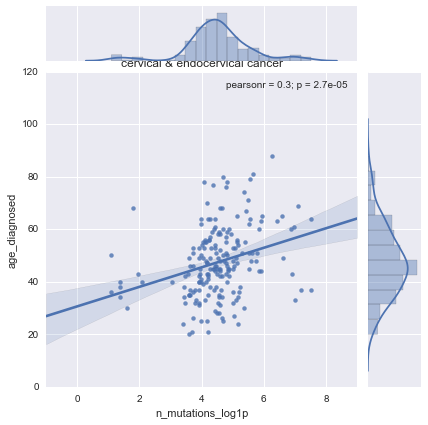

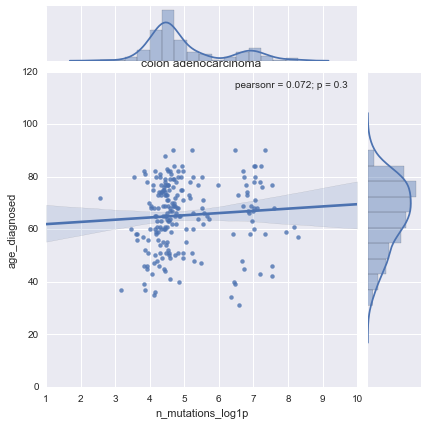

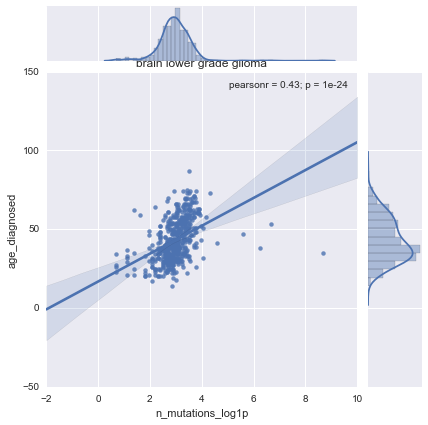

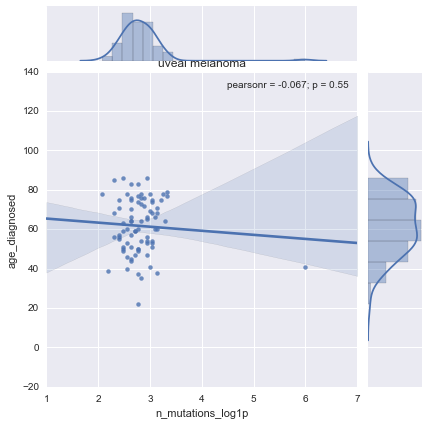

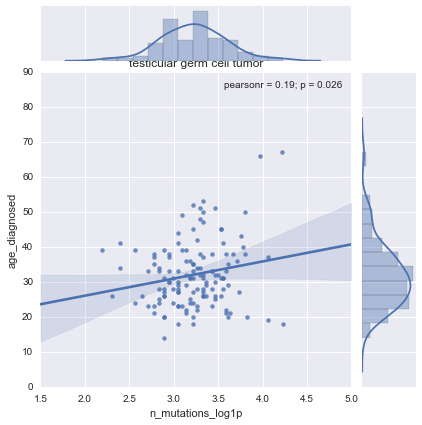

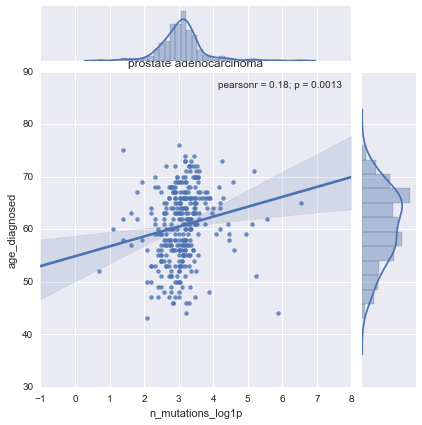

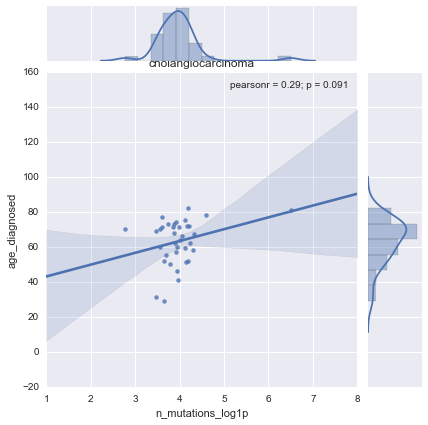

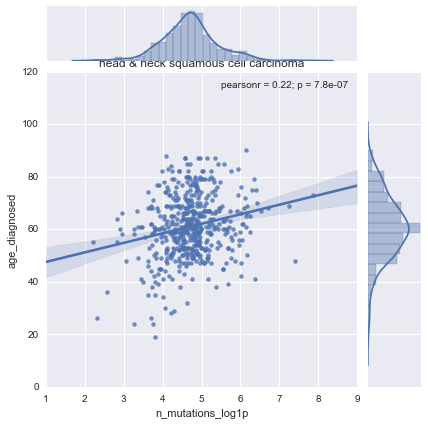

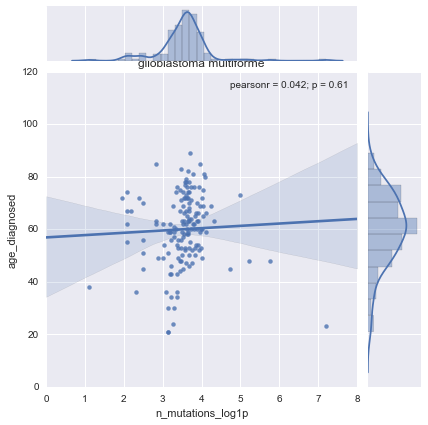

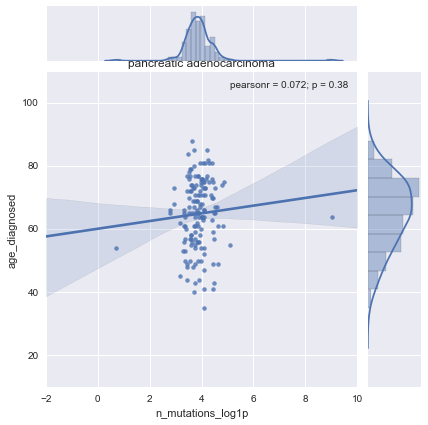

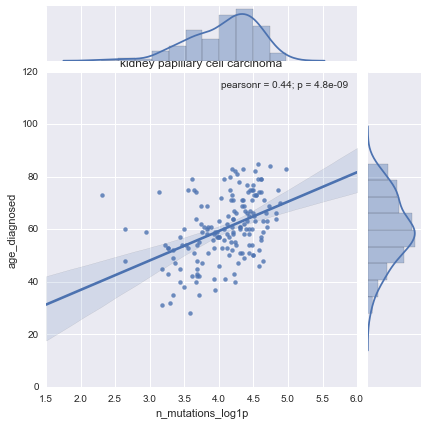

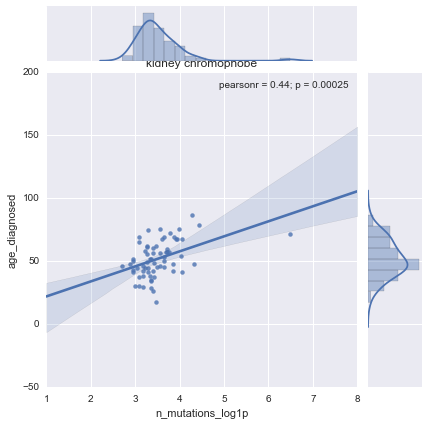

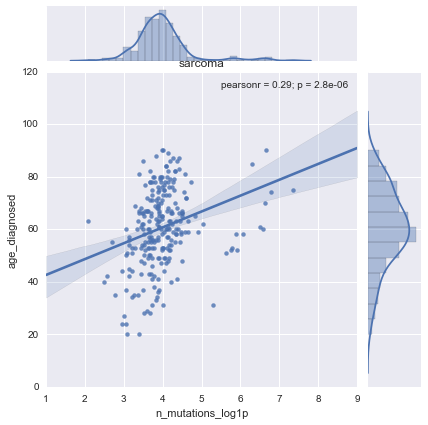

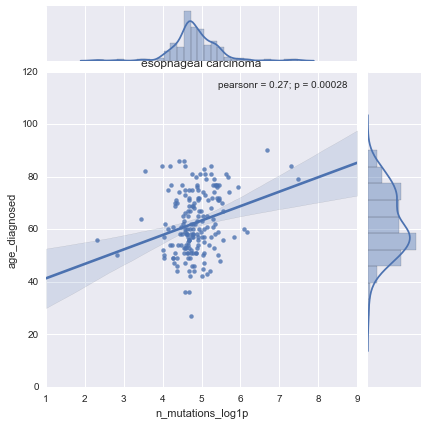

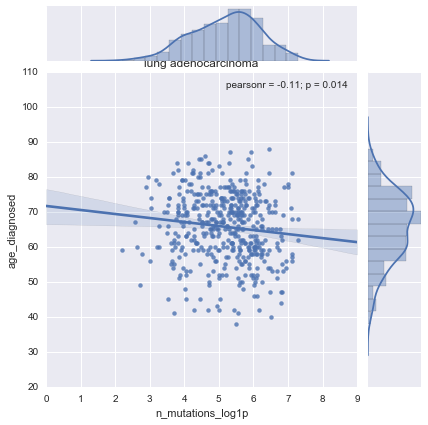

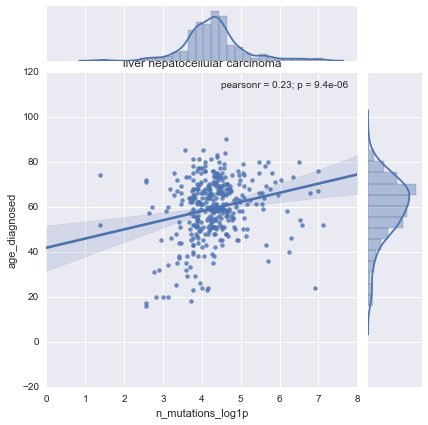

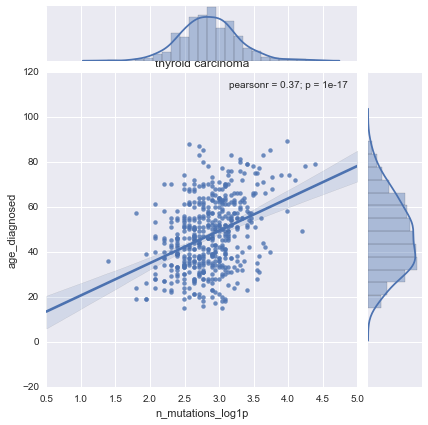

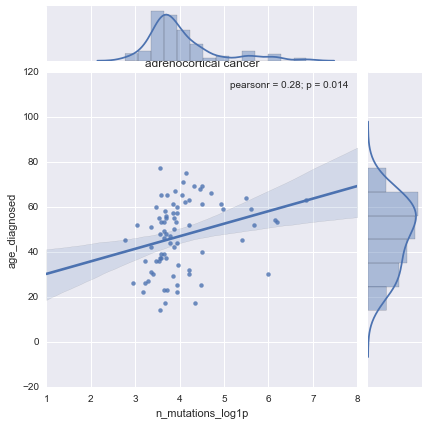

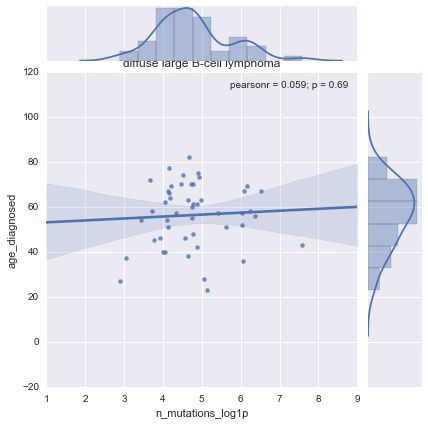

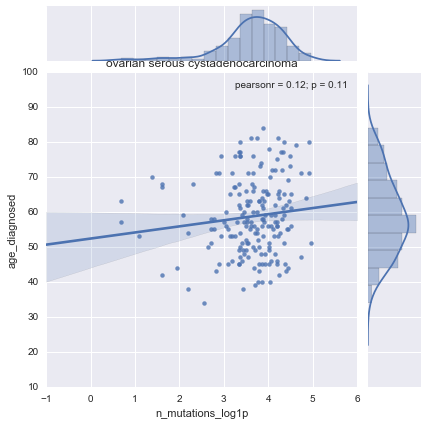

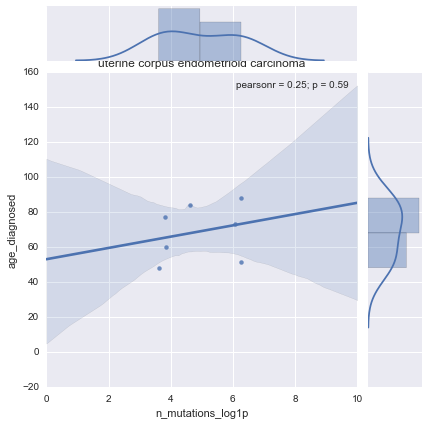

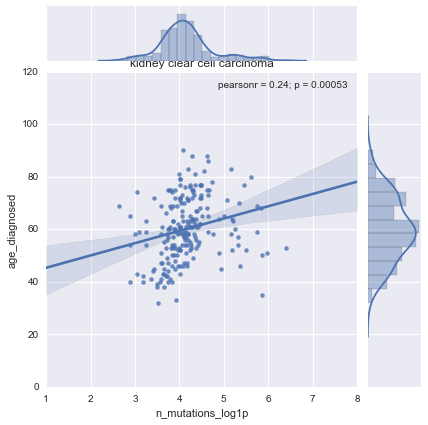

In [16]:
for disease in set(samples_df.disease):
    sns.jointplot('n_mutations_log1p',
                  'age_diagnosed',
                  data=covariates_df[samples_df.disease==disease],
                  kind='reg')
    plt.title(disease)
    plt.show()

These seem to affected by outliers. Standard linear regression assumes errors are normally distributed, which have thin tails that are skewed by outliers. It would be possible to do a Bayesian linear regression, replacing the normal with a thicker tailed Student-t. But perhaps there are simpler options.

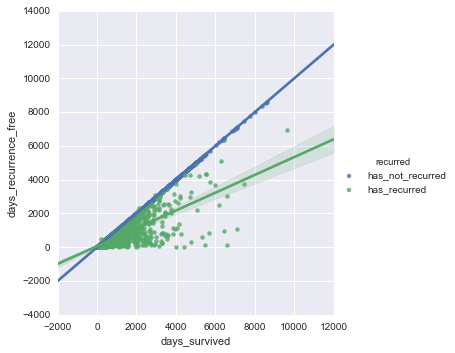

In [17]:
sns.lmplot('days_survived', 'days_recurrence_free', data=samples_df, hue='recurred')
plt.show()

This correlation makes sense, and once we impute either <code>days_survived</code> or <code>days_recurrence_free</code>, we should be able to get the other. Though I am not quite sure how to go about that...